### Citations -
https://github.com/tensorflow

In [1]:
# Mount into drive 
from google.colab import drive 
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
cd '/content/drive/MyDrive/FINALPROJECT_DL_Collab/'

/content/drive/MyDrive/FINALPROJECT_DL_Collab


In [3]:
# !pip install -q kaggle

In [4]:
# #Configuration environment
# import os

# os.environ['KAGGLE_USERNAME'] = "vipulkoti" # username from the json file
# os.environ['KAGGLE_KEY'] = "59c15e9d2ada3bedf6072af79f596e65" # key from the json file

In [5]:
# !kaggle datasets download -d sayanf/flickr8k

In [6]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.6 MB/s eta 0:00:00


In [7]:
import concurrent.futures
import collections
import dataclasses
import hashlib
import itertools
import json
import math
import os
import pathlib
import random
import re
import string
import time
import urllib.request

import einops
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import requests
import tqdm

import tensorflow as tf

Check GPU

In [8]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### Data preprocessing and Dataset cleanup

#### Download dataset from: https://www.kaggle.com/datasets/sayanf/flickr8k

Total Images in Dataset - 8091

Sample Caption Details - 
1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg#0	A black dog and a spotted dog are fighting
1001773457_577c3a7d70.jpg#1	A black dog and a tri-colored dog playing with each other on the road .
1001773457_577c3a7d70.jpg#2	A black dog and a white dog with brown spots are staring at each other in the street .



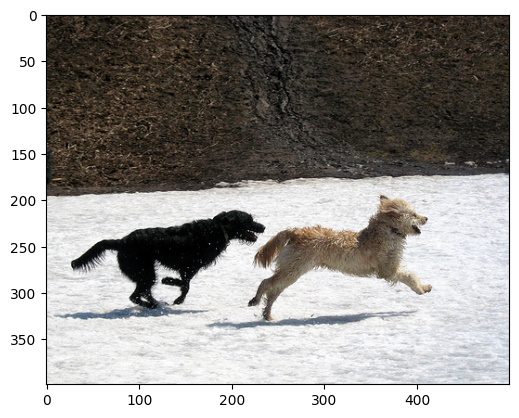

[b'A black dog is running after a white dog in the snow .'
 b'Black dog chasing brown dog through snow'
 b'Two dogs chase each other across the snowy ground .'
 b'Two dogs play together in the snow .'
 b'Two dogs running through a low lying body of water .']


In [9]:
image_dir_path = "./archive/Flickr8k_Dataset/"
caption_file_path = './archive/Flickr8k_text/Flickr8k.token.txt'
train_img_file_path = './archive/Flickr8k_text/Flickr_8k.trainImages.txt'
test_img_file_path = './archive/Flickr8k_text/Flickr_8k.testImages.txt'

images = os.listdir(image_dir_path)
captions_text = open(caption_file_path,'r').read()

print("Total Images in Dataset - {}\n".format(len(images)))
print("Sample Caption Details - \n{}\n".format(captions_text[:696]))

captions_dict = dict()
for line in captions_text.split('\n'):
    tokens = line.split()
    if len(line) > 2:
        image_id = tokens[0].split('#')[0]
        image_desc = ' '.join(tokens[1:])
        if image_id not in captions_dict:
            captions_dict[image_id] = list()
        captions_dict[image_id].append(image_desc)

train_images = pathlib.Path(train_img_file_path).read_text().splitlines()
train_captions = [((image_dir_path+file_name), captions_dict[file_name]) for file_name in train_images]

test_images = pathlib.Path(test_img_file_path).read_text().splitlines()
test_captions = [((image_dir_path+file_name), captions_dict[file_name]) for file_name in test_images]

train_dataset = tf.data.experimental.from_list(train_captions)
test_dataset = tf.data.experimental.from_list(test_captions)

for img_path, captions in train_dataset.take(1):
    numpy_images = img_path.numpy()
    numpy_labels = captions.numpy()
    
pic = numpy_images.decode()
label = numpy_labels
x=plt.imread(pic)
plt.imshow(x)
plt.show()
print(numpy_labels)

### Pre-process Images (Using pre-Trained MobileNetV3Small)

`include_top=False` returns the model without the final classification layer, as we need feature vector.

In [10]:
# IMAGE_SHAPE=(224, 224, 3)
# mobilenet = tf.keras.applications.MobileNetV3Small(
#     input_shape=IMAGE_SHAPE,
#     include_top=False,
#     include_preprocessing=True)
# mobilenet.trainable=False

In [11]:
# IMAGE_SHAPE=(299, 299, 3)
# mobilenet = tf.keras.applications.inception_v3(
#     input_shape=IMAGE_SHAPE,
#     include_top=False,
#     include_preprocessing=True,
#     weights='imagenet')
# mobilenet.trainable=False

In [12]:
IMAGE_SHAPE=(224, 224, 3)
mobilenet = tf.keras.applications.VGG16(weights='imagenet',
    input_shape=IMAGE_SHAPE,
    include_top=False,)
mobilenet.trainable=False

58889256/58889256 [==============================] - 2s 0us/step


Load an image and resize it for the model:

In [13]:
def imageLoadResize(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SHAPE[:-1])
    return img

In [14]:
# def load_image(image_path):
#     img = tf.io.read_file(image_path)
#     img = tf.image.decode_jpeg(img, channels=3)
#     img = tf.image.resize(img, (299, 299))
#     img = tf.keras.applications.inception_v3.preprocess_input(img)
#     return img, image_path

In [15]:
# image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
# new_input = image_model.input
# hidden_layer = image_model.layers[-1].output
# image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [16]:
# test_img = load_image(pic)
# print(test_img)
# # print(image_features_extract_model(test_img))

In [17]:
# from keras.preprocessing import image
# from keras.applications.vgg16 import VGG16
# from keras.applications.vgg16 import preprocess_input
# import numpy as np

# model = VGG16(weights='imagenet', include_top=False)
# # model.summary()

# img_path = pic
# img = tf.io.read_file(img_path)
# img = tf.image.decode_jpeg(img, channels=3)
# img = tf.image.resize(img, (224, 224))
# img_data = preprocess_input(img)
# p

# vgg16_feature = model.predict(img_data)

# print(vgg16_feature.shape)

Feature Vector of image

In [18]:
test_img = imageLoadResize(pic)[tf.newaxis, :]
print(test_img.shape)
print(mobilenet(test_img).shape)

(1, 224, 224, 3)
(1, 7, 7, 512)


In [19]:
#### Reference Code
# def preprocess_image(img_path):
#     image = tf.io.read_file(img_path)
#     image = tf.image.decode_jpeg(image, channels=3)
#     # preprocess all the images to the same size, i.e, 299×299
#     image = tf.image.resize(image, (299, 299))
#     image = tf.keras.applications.inception_v3.preprocess_input(image)
#     return image, img_path

# cnn_model = tf.keras.applications.InceptionV3(include_top=False)
# cnn_input = cnn_model.input
# cnn_hidden_layer = cnn_model.layers[-1].output

#### Reference code

### Pre Process Text (Using tensorflow/keras provided functions)

Basic Text clean-up to convert all text to lower case and remove punctuations
Creating Vocabulary with limited words; Caption Tokenizer and padding

In [20]:
def standardize(s):
  s = tf.strings.lower(s)
  s = tf.strings.regex_replace(s, f'[{re.escape(string.punctuation)}]', '')
  s = tf.strings.join(['[START]', s, '[END]'], separator=' ')
  return s

In [21]:
vocabulary_size = 5000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    ragged=True)

In [22]:
tokenizer.adapt(train_dataset.map(lambda fp,txt: txt).unbatch().batch(1024))

In [23]:
tokenizer.get_vocabulary()[:10]

['', '[UNK]', 'a', '[START]', '[END]', 'in', 'the', 'on', 'is', 'and']

In [24]:
t = tokenizer([['a cat is sitting on a dog'], ['a robot is dancing']])
t

<tf.RaggedTensor [[3, 2, 655, 8, 49, 7, 2, 10, 4], [3, 2, 1937, 8, 326, 4]]>

In [25]:
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())

index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

w = index_to_word(t)

tf.strings.reduce_join(w, separator=' ', axis=-1).numpy()

array([b'[START] a cat is sitting on a dog [END]',
       b'[START] a robot is dancing [END]'], dtype=object)

Below function makes (image,caption) pair from 1:5 to 1:1

In [26]:
def match_shapes(images, captions):
  caption_shape = einops.parse_shape(captions, 'b c')
  captions = einops.rearrange(captions, 'b c -> (b c)')
  images = einops.repeat(
      images, 'b ... -> (b c) ...',
      c = caption_shape['c'])
  return images, captions

In [27]:
# the code below convert image and paths in 1:1 , so 32 images have 5 each captions, it truns total 160 paths (5 paths repetitive for one image) and 160 captions
for ex_paths, ex_captions in train_dataset.batch(32).take(1):
  break
print("(image,caption) is 1:5")
print('image paths:', ex_paths.shape)
print('captions:', ex_captions.shape)
# print(ex_captions)

ex_paths, ex_captions = match_shapes(images=ex_paths, captions=ex_captions)
print("\n(image,caption) is 1:1 => 32*5=160")
print('image_paths:', ex_paths.shape)
print('captions:', ex_captions.shape)
# print(ex_captions)


(image,caption) is 1:5
image paths: (32,)
captions: (32, 5)

(image,caption) is 1:1 => 32*5=160
image_paths: (160,)
captions: (160,)


For caption generation, tokens are both an input and the labels, shifted by one step.

Below function converts `(images, texts)` pair to an `((images, input_tokens), label_tokens)` pair

In [28]:
def prepare_txt(image, captions):
  tokens = tokenizer(captions)
  input_tokens = tokens[..., :-1]
  label_tokens = tokens[..., 1:]
  return (image, input_tokens), label_tokens

Shuffle and Batch Images, Tokenize the train and test captions

In [29]:
def prepare_dataset(ds, tokenizer, batch_size=32, shuffle_buffer=1000):
  ds = (ds
        .shuffle(10000)
        .map(lambda path, caption: (imageLoadResize(path), caption))
        .apply(tf.data.experimental.ignore_errors())
        .batch(batch_size))

  def to_tensor(inputs, labels):
    (images, in_token), out_token = inputs, labels
    return (images, in_token.to_tensor()), out_token.to_tensor()

  return (ds
          .map(match_shapes, tf.data.AUTOTUNE)
          .unbatch()
          .shuffle(shuffle_buffer)
          .batch(batch_size)
          .map(prepare_txt, tf.data.AUTOTUNE)
          .map(to_tensor, tf.data.AUTOTUNE)
          )

You could install the feature extractor in your model and train on the datasets like this:

In [30]:
new_train_dataset_raw = prepare_dataset(train_dataset, tokenizer)
new_train_dataset_raw.element_spec

Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.


((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

In [31]:
new_test_dataset_raw = prepare_dataset(test_dataset, tokenizer)
new_test_dataset_raw.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

## Extract Features
Feature extraction using CNN model and loading data in batches for training

In [32]:
def extract_features(ds, save_path, image_model, tokenizer, shards=10, batch_size=32):
  # Load the images and make batches.
  ds = (ds
        .map(lambda path, caption: (imageLoadResize(path), caption))
        .apply(tf.data.experimental.ignore_errors())
        .batch(batch_size))

  # Run the feature extractor on each batch
  # Don't do this in a .map, because tf.data runs on the CPU. 
  def gen():
    for (images, captions) in tqdm.tqdm(ds): 
      feature_maps = image_model(images)

      feature_maps, captions = match_shapes(feature_maps, captions)
      yield feature_maps, captions

  # Wrap the generator in a new tf.data.Dataset.
  new_ds = tf.data.Dataset.from_generator(
      gen,
      output_signature=(
          tf.TensorSpec(shape=image_model.output_shape),
          tf.TensorSpec(shape=(None,), dtype=tf.string)))

  # Apply the tokenization 
  new_ds = (new_ds
            .map(prepare_txt, tf.data.AUTOTUNE)
            .unbatch()
            .shuffle(1000))
  # Save the dataset into shard files.
  def shard_func(i, item):
    return i % shards
  new_ds.enumerate().save(save_path, shard_func=shard_func)

In [33]:
def load_dataset(save_path, batch_size=32, shuffle=1000, cycle_length=2):
  def custom_reader_func(datasets):
    datasets = datasets.shuffle(1000)
    return datasets.interleave(lambda x: x, cycle_length=cycle_length)
  
  ds = tf.data.Dataset.load(save_path, reader_func=custom_reader_func)

  def drop_index(i, x):
    return x

  ds = (ds
        .map(drop_index, tf.data.AUTOTUNE)
        .shuffle(shuffle)
        .padded_batch(batch_size)
        .prefetch(tf.data.AUTOTUNE))
  return ds

In [34]:
#not run once done, run only if different model for feature extraction
# extract_features(train_dataset, 'train_cacheVGG', mobilenet, tokenizer)
# extract_features(test_dataset, 'test_cacheVGG', mobilenet, tokenizer)



In [35]:
new_train_dataset = load_dataset('train_cacheVGG')
new_test_dataset = load_dataset('test_cacheVGG')

## Training Dataset

Below is the detail of train tensor

In [36]:
new_train_dataset.element_spec

((TensorSpec(shape=(None, 7, 7, 512), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

The train dataset is `(input, label)` pairs (Suitable for training with Keras).
The `inputs` comprise pairs of `(images, input_tokens)` where the `images` is vector after feature extraction.
The model consumes the text up to each position in the `input_tokens` and predict the next element in the `labels.

In [37]:
inputs, ex_labels = next(iter(new_train_dataset))
ex_img, ex_in_tok = inputs

print(f"Shape of example images: {ex_img.shape}")
print(f"Shape of example input tokens: {ex_in_tok.shape}")
print(f"Shape of example labels: {ex_labels.shape}")

Shape of example images: (32, 7, 7, 512)
Shape of example input tokens: (32, 24)
Shape of example labels: (32, 24)


In [38]:
# The input tokens and labels are identical, except for being offset by one step.
print(ex_in_tok[0].numpy())
print(ex_labels[0].numpy())

[  3   2  20   8  46   5   6  65  36  52  29  87   9  15 298   0   0   0
   0   0   0   0   0   0]
[  2  20   8  46   5   6  65  36  52  29  87   9  15 298   4   0   0   0
   0   0   0   0   0   0]


# Continuing post Model leaving model for now

# ==============================================

# A Transformer decoder model

This model assumes that the pretrained image encoder is sufficient, and just focuses on building the text decoder. This tutorial uses a 2-layer Transformer-decoder.

The implementations are almost identical to those in the [Transformers tutorial](https://www.tensorflow.org/text/tutorials/transformer). Refer back to it for more details.

<table>
<tr>
  <th>The Transformer encoder and decoder.</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-1layer-words.png"/>
  </td>
</tr>
</table>

The model will be implemented in three main parts: 

1. Input - The token embedding and positional encoding (`SeqEmbedding`).
1. Decoder - A stack of transformer decoder layers (`DecoderLayer`) where each contains:
   1. A causal self attention later (`CausalSelfAttention`), where each output location can attend to the output so far.
   1. A cross attention layer (`CrossAttention`) where each output location can attend to the input image.
   1. A feed forward network (`FeedForward`) layer which further processes each output location independently.
1. Output - A multiclass-classification over the output vocabulary.


### Input

The input text has already been split up into tokens and converted to sequences of IDs. 

Remember that unlike a CNN or RNN the Transformer's attention layers are invariant to the order of the sequence. Without some positional input, it just sees an unordered set not a sequence. So in addition to a simple vector embedding for each token ID, the embedding layer will also include an embedding for each position in the sequence.

The `SeqEmbedding` layer defined below:

- It looks up the embedding vector for each token.
- It looks up an embedding vector for each sequence location.
- It adds the two together.
- It uses `mask_zero=True` to initialize the keras-masks for the model.

Note: This implementation learns the position embeddings instead of using fixed embeddings like in the [Transformer tutorial](https://www.tensorflow.org/text/tutorials/transformer). Learning the embeddings is slightly less code, but doesn't generalize to longer sequences.

In [39]:
class SeqEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, max_length, depth):
    super().__init__()
    self.pos_embedding = tf.keras.layers.Embedding(input_dim=max_length, output_dim=depth)

    self.token_embedding = tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=depth,
        mask_zero=True)
    
    self.add = tf.keras.layers.Add()

  def call(self, seq):
    seq = self.token_embedding(seq) # (batch, seq, depth)

    x = tf.range(tf.shape(seq)[1])  # (seq)
    x = x[tf.newaxis, :]  # (1, seq)
    x = self.pos_embedding(x)  # (1, seq, depth)

    return self.add([seq,x])

### Decoder

The decoder is a standard Transformer-decoder, it contains a stack of `DecoderLayers` where each contains three sublayers: a `CausalSelfAttention`, a `CrossAttention`, and a`FeedForward`. The implementations are almost identical to the [Transformer tutorial](https://www.tensorflow.org/text/tutorials/transformer), refer to it for more details.

The `CausalSelfAttention` layer is below:

In [40]:
class CausalSelfAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    # Use Add instead of + so the keras mask propagates through.
    self.add = tf.keras.layers.Add() 
    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x):
    attn = self.mha(query=x, value=x,
                    use_causal_mask=True)
    x = self.add([x, attn])
    return self.layernorm(x)


The `CrossAttention` layer is below. Note the use of `return_attention_scores`.

In [41]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self,**kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.add = tf.keras.layers.Add() 
    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x, y, **kwargs):
    attn, attention_scores = self.mha(
             query=x, value=y,
             return_attention_scores=True)
    
    self.last_attention_scores = attention_scores
    # print(x)
    # print(attn)

    x = self.add([x, attn])
    # print('vip ',x)
    return self.layernorm(x)

In [42]:
class MultiCrossAttention(tf.keras.layers.Layer):
  def __init__(self,**kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.multiply = tf.keras.layers.Multiply() 
    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x, y, **kwargs):
    # print(x)
    # print(y)
    attn, attention_scores = self.mha(
             query=x, value=y,
             return_attention_scores=True)
    
    self.last_attention_scores = attention_scores

    # x = tf.reduce_sum(attn * x, axis=1)
    # if x.shape == (1,256):
    #   x = tf.expand_dims(x, 1)
    x = self.multiply([x, attn])
    
    return self.layernorm(x)

In [43]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        # Initialize the attention layer with two dense layers and a final dense layer that produces scalar scores
        super().__init__()
        self.W1 = tf.keras.layers.Dense(units, name='dense1')
        self.W2 = tf.keras.layers.Dense(units, name='dense2')
        self.V = tf.keras.layers.Dense(1, name='dense3')
        self.layernorm = tf.keras.layers.LayerNormalization()

    def call(self, features, hidden):
        # Compute attention scores
        # Transform the hidden state to match the shape of the features tensor
        query = tf.expand_dims(hidden, 1)
        # Project the features tensor and the query tensor onto a shared hidden space
        # The resulting key tensor has shape (batch_size, 64, units)
        key = self.W1(features)
        # The resulting value tensor has shape (batch_size, 1, units)
        value = self.W2(query)
        # Compute the scores as a dot product between the key and value tensors
        # The resulting score tensor has shape (batch_size, 64, 1)
        score = tf.matmul(tf.nn.tanh(key + value), self.V(1))

        # Compute attention weights and context vector
        # Apply softmax to the scores to obtain the attention weights
        # The resulting attention_weights tensor has shape (batch_size, 64, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        # Compute the context vector as a weighted sum of the features
        # The resulting context_vector tensor has shape (batch_size, units)
        context_vector = tf.reduce_sum(attention_weights * features, axis=1)

        # return context_vector, attention_weights
        return self.layernorm(context_vector)

In [44]:
#Attention notes (cleanup after implementation)

# # Attention Function
#    '''e(ij) = f(s(t-1),h(j))'''
#    ''' e(ij) = Vattn(T)*tanh(Uattn * h(j) + Wattn * s(t))'''

#    score = self.Vattn(tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis)))

#    # self.Uattn(features) : (64,49,512)
#    # self.Wattn(hidden_with_time_axis) : (64,1,512)
#    # tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis)) : (64,49,512)
#    # self.Vattn(tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis))) : (64,49,1) ==> score

#    # you get 1 at the last axis because you are applying score to self.Vattn
#    # Then find Probability using Softmax
#    '''attention_weights(alpha(ij)) = softmax(e(ij))'''

#    attention_weights = tf.nn.softmax(score, axis=1)

#    # attention_weights shape == (64, 49, 1)
#    # Give weights to the different pixels in the image
#    ''' C(t) = Summation(j=1 to T) (attention_weights * VGG-16 features) '''

#    context_vector = attention_weights * features
#    context_vector = tf.reduce_sum(context_vector, axis=1)

#    # Context Vector(64,256) = AttentionWeights(64,49,1) * features(64,49,256)
#    # context_vector shape after sum == (64, 256)
#    # x shape after passing through embedding == (64, 1, 256)

#    x = self.embedding(x)
#    # x shape after concatenation == (64, 1,  512)

#    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
#    # passing the concatenated vector to the GRU

The `FeedForward` layer is below. Remember that a `layers.Dense` layer is applied to the last axis of the input. The input will have a shape of `(batch, sequence, channels)`, so it automatically applies pointwise across the `batch` and `sequence` axes.  

In [45]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, units, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
        tf.keras.layers.Dense(units=2*units, activation='relu'),
        tf.keras.layers.Dense(units=units),
        tf.keras.layers.Dropout(rate=dropout_rate),
    ])

    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x):
    x = x + self.seq(x)
    return self.layernorm(x)


Next arrange these three layers into a larger `DecoderLayer`. Each decoder layer applies the three smaller layers in sequence. After each sublayer the shape of `out_seq` is `(batch, sequence, channels)`. The decoder layer also returns the `attention_scores` for later visualizations.

In [46]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, units, num_heads=1, dropout_rate=0.1):
    super().__init__()
    
    self.self_attention = CausalSelfAttention(num_heads=num_heads,
                                              key_dim=units,
                                              dropout=dropout_rate)
    self.cross_attention = CrossAttention(num_heads=num_heads,
                                          key_dim=units,
                                          dropout=dropout_rate)
    self.bhanuden_attention = BahdanauAttention(units)
    self.multi_cross_attention = MultiCrossAttention(num_heads=num_heads,
                                          key_dim=units,
                                          dropout=dropout_rate)

    self.ff = FeedForward(units=units, dropout_rate=dropout_rate)
    self.hidden = tf.zeros((32, units)) #batch size , unit
      
#CHANGE: change here for attention (Comment/Uncomment)
  def call(self, inputs, training=False):
    in_seq, out_seq = inputs
    # hidden = 

    # Text input
    out_seq = self.self_attention(out_seq)

    out_seq = self.cross_attention(out_seq, in_seq)
    # print('vip ',out_seq)
    # print('vip2 ',in_seq)

    # out_seq = self.multi_cross_attention(out_seq, in_seq)
    
    self.last_attention_scores = self.cross_attention.last_attention_scores

    # out_seq = self.bhanuden_attention(in_seq, self.hidden)

    out_seq = self.ff(out_seq)

    return out_seq

### Output

At minimum the output layer needs a `layers.Dense` layer to generate logit-predictions for each token at each location.

But there are a few other features you can add to make this work a little better:

1. **Handle bad tokens**: The model will be generating text. It should
   never generate a pad, unknown, or start token (`''`, `'[UNK]'`, 
   `'[START]'`). So set the bias for these to a large negative value.

   > Note: You'll need to ignore these tokens in the loss function as well. 

2. **Smart initialization**: The default initialization of a dense layer will
  give a model that initially predicts each token with almost uniform
  likelihood. The actual token distribution is far from uniform. The
  optimal value for the initial bias of the output layer is the log of the
  probability of each token. So include an `adapt` method to count the tokens
  and set the optimal initial bias. This reduces the initial loss from the
  entropy of the uniform distribution (`log(vocabulary_size)`) to the marginal
  entropy of the distribution (`-p*log(p)`).


In [47]:
#@title
class TokenOutput(tf.keras.layers.Layer):
  def __init__(self, tokenizer, banned_tokens=('', '[UNK]', '[START]'), **kwargs):
    super().__init__()
    
    self.dense = tf.keras.layers.Dense(
        units=tokenizer.vocabulary_size(), **kwargs)
    self.tokenizer = tokenizer
    self.banned_tokens = banned_tokens

    self.bias = None

  def adapt(self, ds):
    counts = collections.Counter()
    vocab_dict = {name: id 
                  for id, name in enumerate(self.tokenizer.get_vocabulary())}

    for tokens in tqdm.tqdm(ds):
      counts.update(tokens.numpy().flatten())

    counts_arr = np.zeros(shape=(self.tokenizer.vocabulary_size(),))
    counts_arr[np.array(list(counts.keys()), dtype=np.int32)] = list(counts.values())

    counts_arr = counts_arr[:]
    for token in self.banned_tokens:
      counts_arr[vocab_dict[token]] = 0

    total = counts_arr.sum()
    p = counts_arr/total
    p[counts_arr==0] = 1.0
    log_p = np.log(p)  # log(1) == 0

    entropy = -(log_p*p).sum()

    print()
    print(f"Uniform entropy: {np.log(self.tokenizer.vocabulary_size()):0.2f}")
    print(f"Marginal entropy: {entropy:0.2f}")

    self.bias = log_p
    self.bias[counts_arr==0] = -1e9

  def call(self, x):
    x = self.dense(x)
    # TODO(b/250038731): Fix this.
    # An Add layer doesn't work because of the different shapes.
    # This clears the mask, that's okay because it prevents keras from rescaling
    # the losses.
    return x + self.bias


The smart initialization will significantly reduce the initial loss:

In [48]:
output_layer = TokenOutput(tokenizer, banned_tokens=('', '[UNK]', '[START]'))
# This might run a little faster if the dataset didn't also have to load the image data.
output_layer.adapt(new_train_dataset_raw.map(lambda inputs, labels: labels))

938it [03:10,  4.93it/s]



Uniform entropy: 8.52
Marginal entropy: 5.29


In [49]:
class Captioner(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, tokenizer, feature_extractor, output_layer, num_layers=1,
               units=256, max_length=50, num_heads=1, dropout_rate=0.1):
    super().__init__()
    self.feature_extractor = feature_extractor
    self.tokenizer = tokenizer
    self.word_to_index = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary())
    self.index_to_word = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary(),
        invert=True) 

    self.seq_embedding = SeqEmbedding(
        vocab_size=tokenizer.vocabulary_size(),
        depth=units,
        max_length=max_length)

    self.decoder_layers = [
        DecoderLayer(units, num_heads=num_heads, dropout_rate=dropout_rate)
        for n in range(num_layers)]

    self.output_layer = output_layer

### Build the model

To build the model, you need to combine several parts:

1. The image `feature_extractor` and the text `tokenizer` and.
1. The `seq_embedding` layer, to convert batches of token-IDs to 
   vectors `(batch, sequence, channels)`.
3. The stack of `DecoderLayers` layers that will process the text and image data.
4. The `output_layer` which returns a pointwise prediction of what the next word should be.

When you call the model, for training, it receives an `image, txt` pair. To make this function more usable, be flexible about the input:

* If the image has 3 channels run it through the feature_extractor. Otherwise assume that it has been already. Similarly
* If the text has dtype `tf.string` run it through the tokenizer.

After that running the model is only a few steps:

1. Flatten the extracted image features, so they can be input to the decoder layers.
2. Look up the token embeddings.
3. Run the stack of `DecoderLayer`s, on the image features and text embeddings.
4. Run the output layer to predict the next token at each position.


# ================================================

# Continuing post Model starting here

In [50]:


# Decorate the method as a Captioner class method
@Captioner.add_method
def call(self, inputs):
    image, text = inputs

    # Apply the feature extractor to RGB images
    if image.shape[-1] == 3:
        image = self.feature_extractor(image)

    # Flatten the feature map
    image = einops.rearrange(image, 'b h w c -> b (h w) c')

    # Tokenize the text if it's a string input
    if text.dtype == tf.string:
        text = tokenizer(text)

    # Embed the sequence
    text = self.seq_embedding(text)

    # Pass the image through each decoder layer
    for decoder_layer in self.decoder_layers:
        text = decoder_layer(inputs=(image, text))

    # Apply the output layer
    text = self.output_layer(text)

    return text


In [51]:
#CHANGE: change here for units dropout num_layers, num_heads
model = Captioner(tokenizer, feature_extractor=mobilenet, output_layer=output_layer,
                  units=128, dropout_rate=0.5, num_layers=2, num_heads=2)

In [52]:
# before training save the weights & reload if you run a new experiment
model.save_weights('model.init')


### Generate captions

While training, generate captions for a test image to see how the training is progressing -

In [53]:
image = imageLoadResize(pic)

In [54]:
@Captioner.add_method
def simple_generator(self, image, temperature=1):
  # Initialize the list of output tokens with a `[START]` token.
  initial = self.word_to_index([['[START]']])
  #Extract the `img_features`
  img_features = self.feature_extractor(image[tf.newaxis, ...])

  tokens = initial
  for n in range(50):
    # Pass `img_features` and `tokens` into the model. It returns a list of logits.
    preds = self((img_features, tokens)).numpy()
    preds = preds[:,-1, :]
    # Choose the next token based on those logits.  
    if temperature==0:
        next = tf.argmax(preds, axis=-1)[:, tf.newaxis]
    else:
        next = tf.random.categorical(preds/temperature, num_samples=1)
    # Add it to the list of tokens, and continue the loop.
    tokens = tf.concat([tokens, next], axis=1)
    
    #If it generates an `'[END]'` token, break out of the loop.
    if next[0] == self.word_to_index('[END]'):
      break
  words = index_to_word(tokens[0, 1:-1])
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  return result.numpy().decode()

Captions from untrained Model

In [55]:
pic

'./archive/Flickr8k_Dataset/2513260012_03d33305cf.jpg'

In [56]:
labelcaption=label[0].decode('utf-8')

In [57]:
for t in (0.0, 0.5, 1.0):
  result = model.simple_generator(image, temperature=t)
  print(result)

a a a a a a a a
a a in in a
african man in hockey a a walk suv


In [58]:
result

'african man in hockey a a walk suv'

In [59]:
# pre trainining Bleu
from nltk.translate.bleu_score import sentence_bleu

score = sentence_bleu(labelcaption, result)
print(f"BELU score: {score*100}")

BELU score: 1.4847776071549902e-229


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

# Completed

The temperature parameter allows you to interpolate between 3 modes:

1. Greedy decoding (`temperature=0.0`) - Chooses the most likely next token at each step.
2. Random sampling according to the logits (`temperature=1.0`).
3. Uniform random sampling (`temperature >> 1.0`). 

Since the model is untrained, and it used the frequency-based initialization, the "greedy" output (first) usually only contains the most common tokens: `['a', '.', '[END]']`.

## Train

To train the model you'll need several additional components:

- The Loss and metrics
- The Optimizer
- Optional Callbacks

### Losses and metrics

Here's an implementation of a masked loss and accuracy:

When calculating the mask for the loss, note the `loss < 1e8`. This term discards the artificial, impossibly high losses for the `banned_tokens`.

In [60]:
def masked_loss(labels, preds):  
  loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels, preds)

  mask = (labels != 0) & (loss < 1e8) 
  mask = tf.cast(mask, loss.dtype)

  loss = loss*mask
  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

def masked_acc(labels, preds):
  mask = tf.cast(labels!=0, tf.float32)
  preds = tf.argmax(preds, axis=-1)
  labels = tf.cast(labels, tf.int64)
  match = tf.cast(preds == labels, mask.dtype)
  acc = tf.reduce_sum(match*mask)/tf.reduce_sum(mask)
  return acc

### Callbacks

For feedback during training setup a `keras.callbacks.Callback` to generate some captions for the surfer image at the end of each epoch.

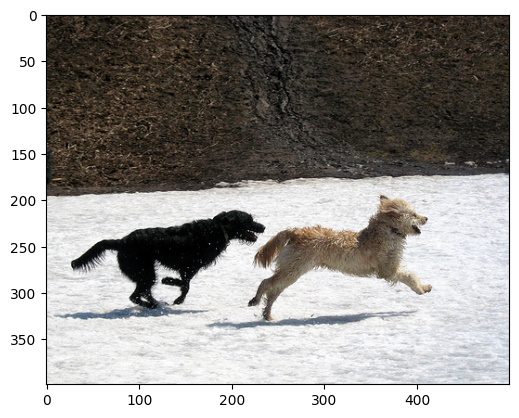

In [61]:
x=plt.imread(pic)
plt.imshow(x)

In [62]:
class GenerateText(tf.keras.callbacks.Callback):
  def __init__(self):
    self.image = imageLoadResize(pic)

  def on_epoch_end(self, epochs=None, logs=None):
    print()
    print()
    for t in (0.0, 0.5, 1.0):
      result = self.model.simple_generator(self.image, temperature=t)
      print(result)
    print()

It generates three output strings, like the earlier example, like before the first is "greedy", choosing the argmax of the logits at each step.

In [63]:
g = GenerateText()
g.model = model
g.on_epoch_end(0)



a a a a a a a a

is in



Also use `callbacks.EarlyStopping` to terminate training when the model starts to overfit.

In [64]:
callbacks = [
    GenerateText(),
    tf.keras.callbacks.EarlyStopping(
        patience=15, restore_best_weights=True)]

### Train

Configure and execute the training.

In [65]:
#CHANGE: change here for learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
           loss=masked_loss,
           metrics=[masked_acc])

For more frequent reporting, use the `Dataset.repeat()` method, and set the `steps_per_epoch` and `validation_steps` arguments to `Model.fit`. 

With this setup on `Flickr8k` a full pass over the dataset is 900+ batches, but below the reporting-epochs are 100 steps.

In [66]:
# start from model weight reload if you run it again

In [67]:
history = model.fit(
    new_train_dataset.repeat(),
    steps_per_epoch=100,
    validation_data=new_test_dataset.repeat(),
    validation_steps=20,
    epochs=100,
    callbacks=callbacks)

Epoch 1/100
 99/100 [============================>.] - ETA: 0s - loss: 5.1747 - masked_acc: 0.1664

a dog dog dog dog dog dog
a dog dog
a black

100/100 [==============================] - 44s 278ms/step - loss: 5.1728 - masked_acc: 0.1668 - val_loss: 4.8805 - val_masked_acc: 0.2169
Epoch 2/100
 99/100 [============================>.] - ETA: 0s - loss: 4.8510 - masked_acc: 0.2280

a dog dog
a dog dog is dog on a white dog
a in with his

100/100 [==============================] - 17s 166ms/step - loss: 4.8480 - masked_acc: 0.2282 - val_loss: 4.6618 - val_masked_acc: 0.2401
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 4.6703 - masked_acc: 0.2461

a dog is dog in a dog
a dog in the is is in a dog in a dog
two through two a men of people dog rowers black dog has a dog her in the on a

100/100 [==============================] - 14s 143ms/step - loss: 4.6703 - masked_acc: 0.2461 - val_loss: 4.5398 - val_masked_acc: 0.2424
Epoch 4/100
100/100 [========================

Plot the loss and accuracy over the training run:

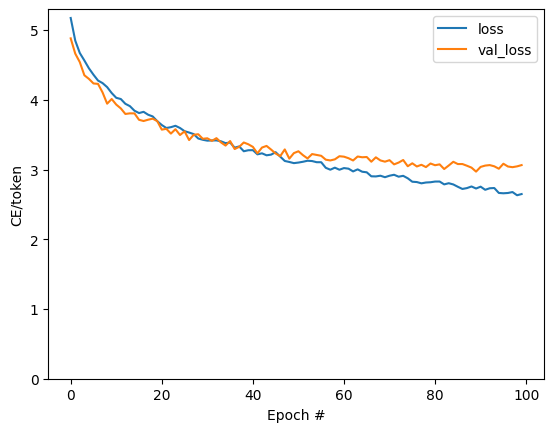

In [68]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

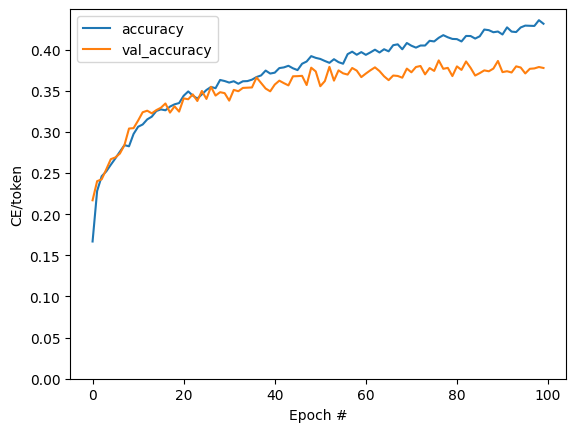

In [69]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

## Attention plots

Now, using the trained model,  run that `simple_generator` method on the image:

In [70]:
result = model.simple_generator(image, temperature=0.0)
result

'two dogs are playing in the snow'

In [71]:
label

array([b'A black dog is running after a white dog in the snow .',
       b'Black dog chasing brown dog through snow',
       b'Two dogs chase each other across the snowy ground .',
       b'Two dogs play together in the snow .',
       b'Two dogs running through a low lying body of water .'],
      dtype=object)

In [72]:
from nltk.translate.bleu_score import corpus_bleu
def get_bleu_Score(pic,captions):
  image = imageLoadResize(pic)
  result = model.simple_generator(image, temperature=0.0)
  res = []
  labels = []
  for i in range(len(label)):
    res.append(result)
    labels.append(label[i].decode('utf-8').split(' '))
    score = corpus_bleu(labels, res)
    return score*100

def get_bleu_top_20(test_captions):
  scores = []
  for (pic, captions) in tqdm.tqdm(test_captions):
    # print(pic)
    scores.append(get_bleu_Score(pic, captions))
  sortedscores = sorted(scores)
  avg20 = sum(sortedscores[-20:])/20
  avg50 = sum(sortedscores[-50:])/50
  avg100 = sum(sortedscores[-100:])/100
  return (avg20, avg50, avg100)

In [73]:
get_bleu_top_20(test_captions)

100%|██████████| 1000/1000 [14:36<00:00,  1.14it/s]


(33.13250475075344, 31.182723841589624, 28.569489132825225)

In [74]:
# post trainining Bleu
from nltk.translate.bleu_score import sentence_bleu
labelcaption = label[3].decode('utf-8')
print(labelcaption)
print(result)
score = sentence_bleu(labelcaption, result)
# print(f"BELU score: {score*100}")

from nltk.translate.bleu_score import corpus_bleu
res = []
labels = []
for i in range(len(label)):
  res.append(result)
  labels.append(label[i].decode('utf-8').split(' '))

# print(res)
# print(labels)
score = corpus_bleu(labels, res)
print(f"BELU Corpus: {score*100}")

# sentence_bleu([reference1, reference2, reference3], hypothesis2,
#     ...     smoothing_function=chencherry.method1)

score = sentence_bleu(labels, result.split(' '))
# print(f"BELU Corpus new: {score*100}")

Two dogs play together in the snow .
two dogs are playing in the snow
BELU Corpus: 19.753365976505037


In [75]:
print(res)

['two dogs are playing in the snow', 'two dogs are playing in the snow', 'two dogs are playing in the snow', 'two dogs are playing in the snow', 'two dogs are playing in the snow']


Split the output back into tokens:

In [76]:
str_tokens = result.split()
str_tokens.append('[END]')

The `DecoderLayers` each cache the attention scores for their `CrossAttention` layer. The shape of each attention map is `(batch=1, heads, sequence, image)`:

In [77]:
attn_maps = [layer.last_attention_scores for layer in model.decoder_layers]
[map.shape for map in attn_maps]

[TensorShape([1, 2, 10, 49]), TensorShape([1, 2, 10, 49])]

So stack the maps along the `batch` axis, then average over the `(batch, heads)` axes, while splitting the `image` axis back into `height, width`:


In [78]:
attention_maps = tf.concat(attn_maps, axis=0)
attention_maps = einops.reduce(
    attention_maps,
    'batch heads sequence (height width) -> sequence height width',
    height=7, width=7,
    reduction='mean')

Now you have a single attention map, for each sequence prediction. The values in each map should sum to `1.`

In [79]:
einops.reduce(attention_maps, 'sequence height width -> sequence', reduction='sum')

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.99999994, 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.99999994, 0.99999994, 1.        , 1.        ],
      dtype=float32)>

So here is where the model was focusing attention while generating each token of the output:

In [80]:
def plot_attention_maps(image, str_tokens, attention_map):
    fig = plt.figure(figsize=(16, 9))

    len_result = len(str_tokens)
    
    titles = []
    for i in range(len_result):
      map = attention_map[i]
      grid_size = max(int(np.ceil(len_result/2)), 2)
      ax = fig.add_subplot(3, grid_size, i+1)
      titles.append(ax.set_title(str_tokens[i]))
      img = ax.imshow(image)
      ax.imshow(map, cmap='gray', alpha=0.6, extent=img.get_extent(),
                clim=[0.0, np.max(map)])

    plt.tight_layout()

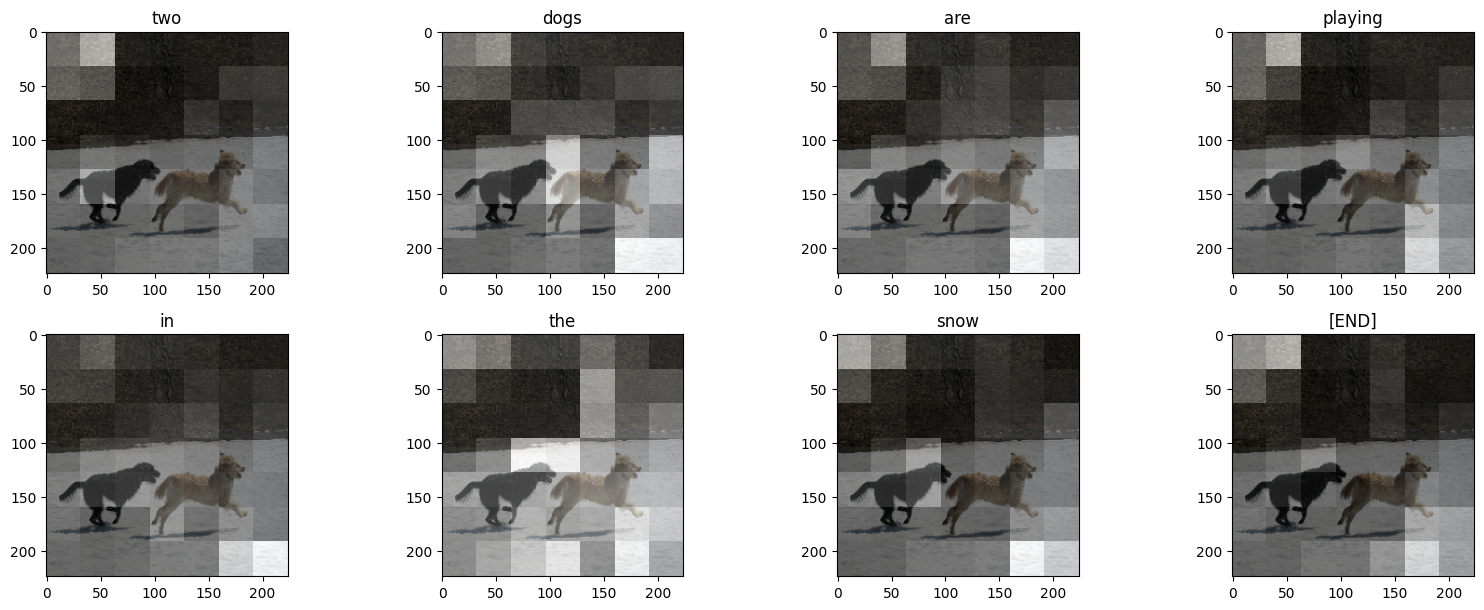

In [81]:
plot_attention_maps(image/255, str_tokens, attention_maps)

Now put that together into a more usable function:

In [82]:
@Captioner.add_method
def run_and_show_attention(self, image, temperature=0.0):
  result_txt = self.simple_generator(image, temperature)
  str_tokens = result_txt.split()
  str_tokens.append('[END]')

  attention_maps = [layer.last_attention_scores for layer in self.decoder_layers]
  attention_maps = tf.concat(attention_maps, axis=0)
  attention_maps = einops.reduce(
      attention_maps,
      'batch heads sequence (height width) -> sequence height width',
      height=7, width=7,
      reduction='mean')
  
  plot_attention_maps(image/255, str_tokens, attention_maps)
  t = plt.suptitle(result_txt)
  t.set_y(1.05)


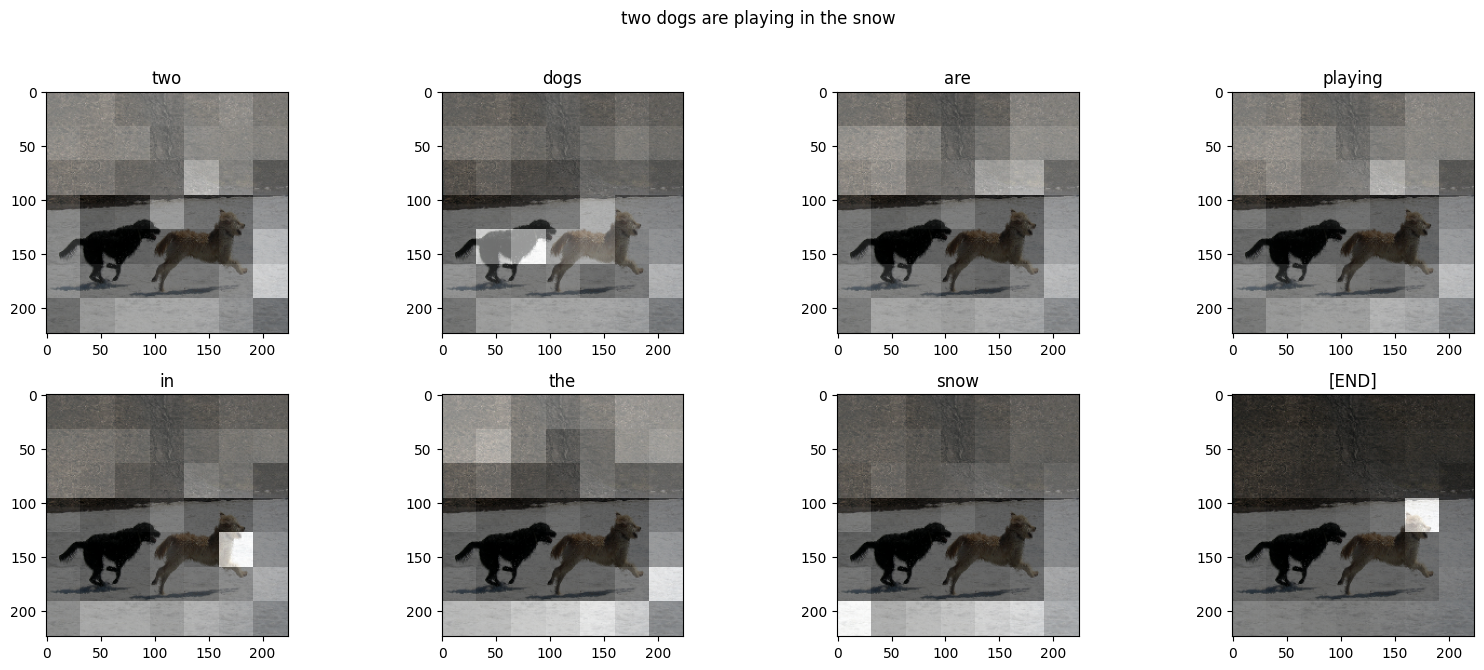

In [83]:
run_and_show_attention(model, image)

## Try it on your own images

For fun, below you're provided a method you can use to caption your own images with the model you've just trained. Keep in mind, it was trained on a relatively small amount of data, and your images may be different from the training data (so be prepared for strange results!)


In [84]:
testimage1 = imageLoadResize("./test_imgs/image_test_1.jpg")
testimage2 = imageLoadResize("./test_imgs/image_test_2.jpg")
testimage3 = imageLoadResize("./test_imgs/image_test_3.jpg")
testimage4 = imageLoadResize("./test_imgs/image_test_4.jpg")
testimage5 = imageLoadResize("./test_imgs/image_test_5.jpg")

NotFoundError: ignored

In [ ]:
run_and_show_attention(model, testimage1)

In [ ]:
run_and_show_attention(model, testimage2)

In [ ]:
run_and_show_attention(model, testimage3)

In [ ]:
run_and_show_attention(model, testimage4)

In [ ]:
run_and_show_attention(model, testimage5)